# Workload Effect on Pitcher Injury

## Goal: 
Determine if we can find:
1) Maximize the predictability of the probability of a pitcher getting injured
2) A causal effect on pitcher injury (e.g., workload, less rest, etc.)

## Background:
For our (1) goal, we want to predict the probability that a pitcher will get injured as a result of workload, rest (or lack thereof), distance traveled, etc. Essentially, given some features regarding what the pitcher has recently done, we can determine the probability that he'll get injured, should he play the next game. In a sense, we're trying to come up with a solution for teams', such that, based on the probability that results from the features we mentioned, a manager or top decision-maker would make judgdment (e.g., our probability induces a certain threshold such that meeting that threshold induces the idea of resting that pitcher instead of letting him pitch and risk an injury). 

Now we understand that there is one glaring issue, and that is that there are many other confounding factors that induce an injury that might not necessarily *be* correlated with workload (e.g., the ball comes back to the pitcher and hits them and takes them out, the pitcher's form wasn't quite right and it caused an inury as a result of straining your body to come up with velo). To account for this, we want to focus on types of injuries that we are confident *are* correlated with workload, and we'll use scientific evidence to support this (e.g., torn UCL). The reason to avoid those other "freak" types of injuries is that they are a potential source of noise/bias as mentioned previously, some injuries are just not a result of workload, meaning it is entirely possible that our models could *learn* from these types of injuries and determine some kind of relationship with the probability of an injury, which we would not want. 

To approach this problem, we want to take a step back and view this problem from another lens. That being: Industrial Engineering. Essentially, we want to view pitchers as "machines," and as a result, we want to estimate the "failure" rate (injury rate) of these "machines" as a function of workload cycles, rest, and travel. Meaning, we want to quantitatively come up with policies for the pitcher that are analogous to process optimizations. As we want to identify when the injury risk of these pitchers accelerate, such that we can prevent this *potential* injury in order to maximize pitcher usage, and minimize any waste, cost, or downtime.

In future iterations, we'd be interested in learning about *true* causal effects in terms of pitcher injuries, and whether or not the factors we talked about (e.g., workload, rest, etc.) have that kind of effect.

## Methodology:


To approach this problem, we first want to understand if there *are* any type of relationships between these workload variables and injury probability. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import requests

pd.set_option('display.max_columns', None)

In [2]:
mlb_injuries = pd.read_csv('mlb_injuries.csv')
mlb_injuries

rank             player pos team    il_type            injury  \
0        1   Justin Verlander  SP  HOU  10-Day IL               Arm   
1        2         Chris Sale  SP  BOS  60-Day IL  Elbow Tommy John   
2        3  Stephen Strasburg  SP  WSH  60-Day IL              Hand   
3        4  Jordan Zimmermann  SP  DET  60-Day IL               Arm   
4        5        Cole Hamels  SP  ATL  60-Day IL               Arm   
...    ...                ...  ..  ...        ...               ...   
5162   628        Cade Horton  SP  CHC  15-Day IL              Ribs   
5163   629    Everson Pereira  OF   TB  10-Day IL              Back   
5164   630         Brett Baty  2B  NYM  10-Day IL           Oblique   
5165   631        Nick Frasso  SP  LAD  60-Day IL       Undisclosed   
5166   632     Vaughn Grissom  2B  BOS  60-Day IL              Foot   

      start_date    end_date  \
0     2020-07-27  2020-09-27   
1     2020-07-24  2020-09-27   
2     2020-08-15  2020-09-27   
3     2020-07-23  2020-09-10   
4     2020-07-23  2020-09-16   
...          ...         ...   
5162  2025-09-25  2025-09-28   
5163  2025-09-26  2025-09-28   
5164  2025-09-27  2025-09-28   
5165  2025-09-27  2025-09-28   
5166  2025-09-09  2025-09-28   

                                             reason_raw  year  
0                      10-Day IL - Arm: 7/27/20-9/27/20  2020  
1         60-Day IL - Elbow Tommy John: 7/24/20-9/27/20  2020  
2                     60-Day IL - Hand: 8/15/20-9/27/20  2020  
3                      60-Day IL - Arm: 7/23/20-9/10/20  2020  
4     60-Day IL - Arm: 7/23/20-9/16/20  60-Day IL - ...  2020  
...                                                 ...   ...  
5162                  15-Day IL - Ribs: 9/25/25-9/28/25  2025  
5163                  10-Day IL - Back: 9/26/25-9/28/25  2025  
5164               10-Day IL - Oblique: 9/27/25-9/28/25  2025  
5165           60-Day IL - Undisclosed: 9/27/25-9/28/25  2025  
5166                   60-Day IL - Foot: 9/9/25-9/28/25  2025  

[5167 rows x 10 columns]

In [7]:
def get_name_birth(id: int):
    """
    A get function to find the birth year and full name of each player based on their mlb id using MLB's Stats API

    Note: you have to be online to run this
    """
    url = f"https://statsapi.mlb.com/api/v1/people/{id}"
    r = requests.get(url).json()
    return [r['people'][0]['birthDate'].split('-')[0], r['people'][0]['fullName'], r['people'][0]['primaryPosition']['abbreviation']]

In [66]:
def load_year_data(year: int):
    """
    Creates the relevant pitcher data for each given year
    Should take about 7-8 min to run
    """
    df = pyb.statcast(f'{year}-03-01', f'{year}-11-30').copy() ## chooses the specific year
    ## cleans up the pitch by pitch data for that season
    df = df[df['game_type'] == 'R'].sort_values(by=['game_date', 'game_pk', 'inning', 'at_bat_number'], ascending=True).reset_index(drop=True).copy()
    df['game_date'] = pd.to_datetime(df['game_date'])
    ## adds the pitch group to simplify pitch usage
    fastball_pitches = ['FF', 'FC', 'SI']
    breaking_pitches = ['CU', 'KC', 'SC', 'SL', 'SV', 'ST']
    offspeed_pitches = ['CH', 'FO', 'FS']
    df['pitch_group'] = df['pitch_type'].apply(lambda x: 'Fastball' if x in fastball_pitches 
                                               else 'Breakingball' if x in breaking_pitches 
                                               else 'Offspeed' if x in offspeed_pitches 
                                               else 'Other')
    ## finds all of the appearances each pitcher made in that season as well as the number of pitches thrown
    df_pitcher_games = df.groupby(['player_name', 'pitcher', 'game_pk', 'game_date'], as_index=False).agg(pitches_thrown=('pitcher', 'count')).copy()
    df_pitcher_games = df_pitcher_games.sort_values(['player_name', 'game_date']).copy()

    ## creates the indicator of what the current season is
    df_pitcher_games['season'] = df_pitcher_games['game_date'].dt.year
    ## finds the previous appearence made for each current date 
    df_pitcher_games['last_start_date'] = (df_pitcher_games.groupby('pitcher')['game_date'].shift(1))
    ## finds the number of pitches that were thrown in the previous appearance made
    df_pitcher_games['pitches_last_start'] = (df_pitcher_games.groupby('pitcher')['pitches_thrown'].shift(1))
    ## the number of rest days the pitcher had before their current appearence
    df_pitcher_games['days_since_last_start'] = ((df_pitcher_games['game_date'] - df_pitcher_games['last_start_date']).dt.days) - 1
    ## a counter for the number appeareance made during the season
    df_pitcher_games['number_start'] = (df_pitcher_games.groupby('pitcher').cumcount() + 1)
    ## a flag for if that appearence made was their first of the season
    df_pitcher_games['first_start'] = (df_pitcher_games['number_start'] == 1).astype(int)

    print('Starting the birthday process')
    ## finds who the real pitchers are in the dataset, as well as their birth year to find age -> takes about 3 min for one season's worth of pitchers
    pitcher_list = df_pitcher_games.groupby(['player_name', 'pitcher'])['number_start'].count().reset_index().copy()
    births = {i: get_name_birth(i) for i in pitcher_list['pitcher'].unique().tolist()}
    names_and_bdays = pd.DataFrame.from_dict(births, orient='index', columns=['birth_year', 'full_name', 'primary_pos']).reset_index(names='id')
    ## keeps it to only pitchers and excludes position players
    names_and_bdays = names_and_bdays[names_and_bdays['primary_pos'].isin(['P', 'TWP'])].reset_index(drop=True).copy() 
    names_and_bdays = names_and_bdays[['id', 'birth_year']].copy()
    print('Finished the birthday process')

    ## only includes the players that are actually pitchers + adds their birth year
    df_pitcher_games = df_pitcher_games[df_pitcher_games['pitcher'].isin(names_and_bdays['id'].unique())].reset_index(drop=True).copy()
    df_pitcher_games = df_pitcher_games.merge(names_and_bdays, how='left', left_on='pitcher', right_on='id').copy()

    ## creates the age column
    df_pitcher_games['age'] = df_pitcher_games['season'] - df_pitcher_games['birth_year'].astype(int)

    ## cleans up the data
    df_pitcher_games = df_pitcher_games[['season', 'player_name', 'pitcher', 'age', 'days_since_last_start', \
                                         'pitches_last_start', 'number_start', 'first_start', \
                                            'last_start_date', 'game_date']].reset_index(drop=True).copy()

    ## the pitch-data for each game for each pitcher
    pitches = (df
               .groupby(['player_name', 'pitcher', 'game_pk', 'game_date', 'pitch_group'], as_index=False)
               .agg(pitches_thrown=('pitch_group', 'count'), 
                    avg_release_speed=('release_speed', 'mean'),
                    avg_spin = ('release_spin_rate', 'mean')
                    )
               ).copy()
    pitches = pitches[pitches['pitch_group'] != 'Other'].reset_index(drop=True).copy()
    ## pivots the table to include columns for each pitch type
    df_wide = (pitches
               .pivot_table(index=['player_name', 'pitcher', 'game_pk', 'game_date'], columns='pitch_group', values=['pitches_thrown', 'avg_release_speed', 'avg_spin'])
               )
    df_wide.columns = [f"{pitch}_{metric}" for metric, pitch in df_wide.columns]
    df_wide = df_wide.reset_index().copy()
    ## normalizes the thrown pitches to be rates
    ## makes sure that the missing pitches are counted as 0 because they technically didn't throw that pitch
    df_wide['Breakingball_pitches_thrown'] = df_wide['Breakingball_pitches_thrown'].fillna(0)
    df_wide['Fastball_pitches_thrown'] = df_wide['Fastball_pitches_thrown'].fillna(0)
    df_wide['Offspeed_pitches_thrown'] = df_wide['Offspeed_pitches_thrown'].fillna(0)
    total_pitches_thrown = df_wide['Breakingball_pitches_thrown'] + df_wide['Fastball_pitches_thrown'] + df_wide['Offspeed_pitches_thrown']
    df_wide['Breakingball_pitches_thrown'] = df_wide['Breakingball_pitches_thrown'] / total_pitches_thrown
    df_wide['Fastball_pitches_thrown'] = df_wide['Fastball_pitches_thrown'] / total_pitches_thrown
    df_wide['Offspeed_pitches_thrown'] = df_wide['Offspeed_pitches_thrown'] / total_pitches_thrown
    df_wide = df_wide[['pitcher', 'game_date', 'Fastball_pitches_thrown', 'Fastball_avg_release_speed', 'Fastball_avg_spin',\
                       'Breakingball_pitches_thrown', 'Breakingball_avg_release_speed', 'Breakingball_avg_spin',\
                        'Offspeed_pitches_thrown', 'Offspeed_avg_release_speed', 'Offspeed_avg_spin'
                        ]]
    df_wide = df_wide.rename(columns={'Fastball_pitches_thrown': 'FB_usage', 'Fastball_avg_release_speed': 'FB_velo', 'Fastball_avg_spin': 'FB_spin',
                                      'Breakingball_pitches_thrown': 'BB_usage', 'Breakingball_avg_release_speed': 'BB_velo', 'Breakingball_avg_spin': 'BB_spin',
                                      'Offspeed_pitches_thrown': 'OS_usage', 'Offspeed_avg_release_speed': 'OS_velo', 'Offspeed_avg_spin': 'OS_spin'
                                      })

    ## adds the pitch level data to each game
    df_pitcher_games = df_pitcher_games.merge(df_wide, how='left', on=['pitcher', 'game_date']).copy()
    pitches_to_shift = ['FB_usage', 'FB_velo', 'FB_spin', 'BB_usage', 'BB_velo', 'BB_spin', 'OS_usage', 'OS_velo', 'OS_spin']
    df_pitcher_games[pitches_to_shift] = (df_pitcher_games.groupby('pitcher')[pitches_to_shift].shift(1))

    ## changes the format of the name to be normalized
    df_pitcher_games['player_name'] = df_pitcher_games['player_name'].apply(lambda x: x.split(', ')[1].strip() + ' ' + x.split(', ')[0].strip()).str.lower()

    return df_pitcher_games

In [67]:
mlb_data = pd.concat([load_year_data(i) for i in range(2020, 2026)], ignore_index=True)

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 97/97 [01:52<00:00,  1.16s/it]
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Starting the birthday process
Finished the birthday process
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [03:52<00:00,  1.06it/s]
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Starting the birthday process
Finished the birthday process
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [03:57<00:00,  1.04it/s]
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Starting the birthday process
Finished the birthday process
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [03:41<00:00,  1.11it/s]
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Starting the birthday process
Finished the birthday process
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [04:11<00:00,  1.02s/it]
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Starting the birthday process
Finished the birthday process
This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [05:09<00:00,  1.26s/it]
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


Starting the birthday process
Finished the birthday process


In [98]:
pitcher_injuries = mlb_injuries[mlb_injuries['pos'].isin(['SP', 'P', 'RP'])].sort_values(by='start_date', ascending=False).reset_index(drop=True).copy()

## fixing the missing data values for start_date and end_date
pitcher_injuries['start_date'] = pitcher_injuries.apply(lambda x: (
    '20' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[2] 
    + '-' 
    + ('0' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip() 
       if int(x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip()) < 10 
       else x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip()
    ) 
    + '-' 
    + ('0' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip() 
       if int(x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip()) < 10 
       else x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip()
    ))
    if pd.isna(x['start_date']) else x['start_date'], axis=1)

pitcher_injuries['start_date'] = pd.to_datetime(pitcher_injuries['start_date']) - pd.Timedelta(days=1)
pitcher_injuries['end_date'] = pitcher_injuries['end_date'].fillna('TBD')

pitcher_injuries = pitcher_injuries[['player', 'il_type', 'injury', 'start_date', 'year']].copy()
pitcher_injuries['player'] = pitcher_injuries['player'].str.lower()
pitcher_injuries['year'] = pitcher_injuries['year'].astype(int)
pitcher_injuries

player    il_type       injury start_date  year
0           nick frasso  60-Day IL  Undisclosed 2025-09-26  2025
1          chris martin  15-Day IL     Shoulder 2025-09-25  2025
2           cade horton  15-Day IL         Ribs 2025-09-24  2025
3          josé berríos  15-Day IL        Elbow 2025-09-24  2025
4           luis garcia  15-Day IL        Thigh 2025-09-24  2025
...                 ...        ...          ...        ...   ...
3006       daniel tillo  10-Day IL        Elbow 2020-07-22  2020
3007          wil crowe  60-Day IL     Shoulder 2023-04-22  2023
3008  jean carlos mejia  60-Day IL     Shoulder 2023-08-14  2023
3009      austin pruitt  60-Day IL         Knee 2024-04-20  2024
3010    graham ashcraft  60-Day IL        Elbow 2024-07-07  2024

[3011 rows x 5 columns]

In [122]:
pitch_injuries = mlb_data.merge(pitcher_injuries, how='left', left_on=['player_name', 'season', 'game_date'], right_on=['player', 'year', 'start_date']).copy()
pitch_injuries = pitch_injuries.drop(columns=['player', 'start_date', 'year']).copy()
workload_injuries = [
    'Arm', 'Elbow', 'Elbow Tommy John', 'Shoulder', 'Biceps', 'Forearm',
    'Wrist', 'Hand', 'Finger', 'Pectoral', 'Neck', 'Back',
    'Hamstring', 'Hip', 'Groin', 'Quad', 'Thigh', 'Calf', 'Ankle', 'Foot',
    'Knee', 'Knee Acl', 'Knee Mcl', 'Toe', 'Leg', 'Shin', 'Glute',
    'Oblique', 'Abdominal', 'Ribs'
]
pitch_injuries['is_workload_inj'] = (pitch_injuries['injury'].isin(workload_injuries)).astype(int)

pitch_injuries = pitch_injuries[pitch_injuries['first_start'] != 1].reset_index(drop=True).copy()

## accounts for the missing data for the type of pitches that weren't thrown
pitch_injuries['fb_thrown'] = (pitch_injuries['FB_usage'] > 0).astype(int)
pitch_injuries['bb_thrown'] = (pitch_injuries['BB_usage'] > 0).astype(int)
pitch_injuries['os_thrown'] = (pitch_injuries['OS_usage'] > 0).astype(int)
pitch_metrics = ['FB_velo', 'FB_spin', 'BB_velo', 'BB_spin', 'OS_velo', 'OS_spin']
pitch_injuries[pitch_metrics] = pitch_injuries[pitch_metrics].fillna(0)
pitch_injuries

season   player_name  pitcher  age  days_since_last_start  \
0         2020  albert abreu   656061   25                   25.0   
1         2020   bryan abreu   650556   23                    2.0   
2         2020   bryan abreu   650556   23                    1.0   
3         2020   bryan abreu   650556   23                    3.0   
4         2020    jason adam   592094   29                    2.0   
...        ...           ...      ...  ...                    ...   
107317    2025  jacob degrom   594798   37                    5.0   
107318    2025  jacob degrom   594798   37                    5.0   
107319    2025  jacob degrom   594798   37                    5.0   
107320    2025  jacob degrom   594798   37                    4.0   
107321    2025  jacob degrom   594798   37                    6.0   

        pitches_last_start  number_start  first_start last_start_date  \
0                       41             2            0      2020-08-08   
1                       31             2            0      2020-07-26   
2                        5             3            0      2020-07-29   
3                       16             4            0      2020-07-31   
4                       25             2            0      2020-08-16   
...                    ...           ...          ...             ...   
107317                  90            26            0      2025-08-25   
107318                  79            27            0      2025-08-31   
107319                  97            28            0      2025-09-06   
107320                  88            29            0      2025-09-12   
107321                  92            30            0      2025-09-17   

        game_date  FB_usage    FB_velo      FB_spin  BB_usage    BB_velo  \
0      2020-09-03  0.487805     96.205       1994.8  0.268293  84.636364   
1      2020-07-29  0.258065     93.275     2320.875  0.741935  84.291304   
2      2020-07-31  0.200000       93.6       2292.0  0.800000     84.875   
3      2020-08-04  0.375000  92.583333       2297.5  0.625000      84.01   
4      2020-08-19  0.720000      95.15  2712.888889  0.160000     81.675   
...           ...       ...        ...          ...       ...        ...   
107317 2025-08-31  0.411111  97.681081  2470.648649  0.466667  90.454762   
107318 2025-09-06  0.518987  97.253659  2488.219512  0.405063   90.63125   
107319 2025-09-12  0.412371     97.325     2518.125  0.453608  91.154545   
107320 2025-09-17  0.556818  97.971429  2545.346939  0.409091  89.291667   
107321 2025-09-24  0.478261  97.586364  2556.772727  0.423913  89.323077   

            BB_spin  OS_usage    OS_velo      OS_spin il_type injury  \
0            2243.0  0.243902      86.68       1934.0     NaN    NaN   
1       2583.782609  0.000000        0.0          0.0     NaN    NaN   
2            2543.5  0.000000        0.0          0.0     NaN    NaN   
3            2618.3  0.000000        0.0          0.0     NaN    NaN   
4            2855.0  0.120000  89.666667  2045.333333     NaN    NaN   
...             ...       ...        ...          ...     ...    ...   
107317  2687.833333  0.122222  90.809091  1617.545455     NaN    NaN   
107318   2647.34375  0.075949  89.233333       1559.0     NaN    NaN   
107319  2692.613636  0.134021  90.338462  1646.153846     NaN    NaN   
107320  2733.472222  0.034091       90.8       1518.0     NaN    NaN   
107321  2753.128205  0.097826  90.111111  1558.333333     NaN    NaN   

        is_workload_inj  fb_thrown  bb_thrown  os_thrown  
0                     0          1          1          1  
1                     0          1          1          0  
2                     0          1          1          0  
3                     0          1          1          0  
4                     0          1          1          1  
...                 ...        ...        ...        ...  
107317                0          1          1          1  
107318                0          1          1       

<Figure size 640x480 with 0 Axes>

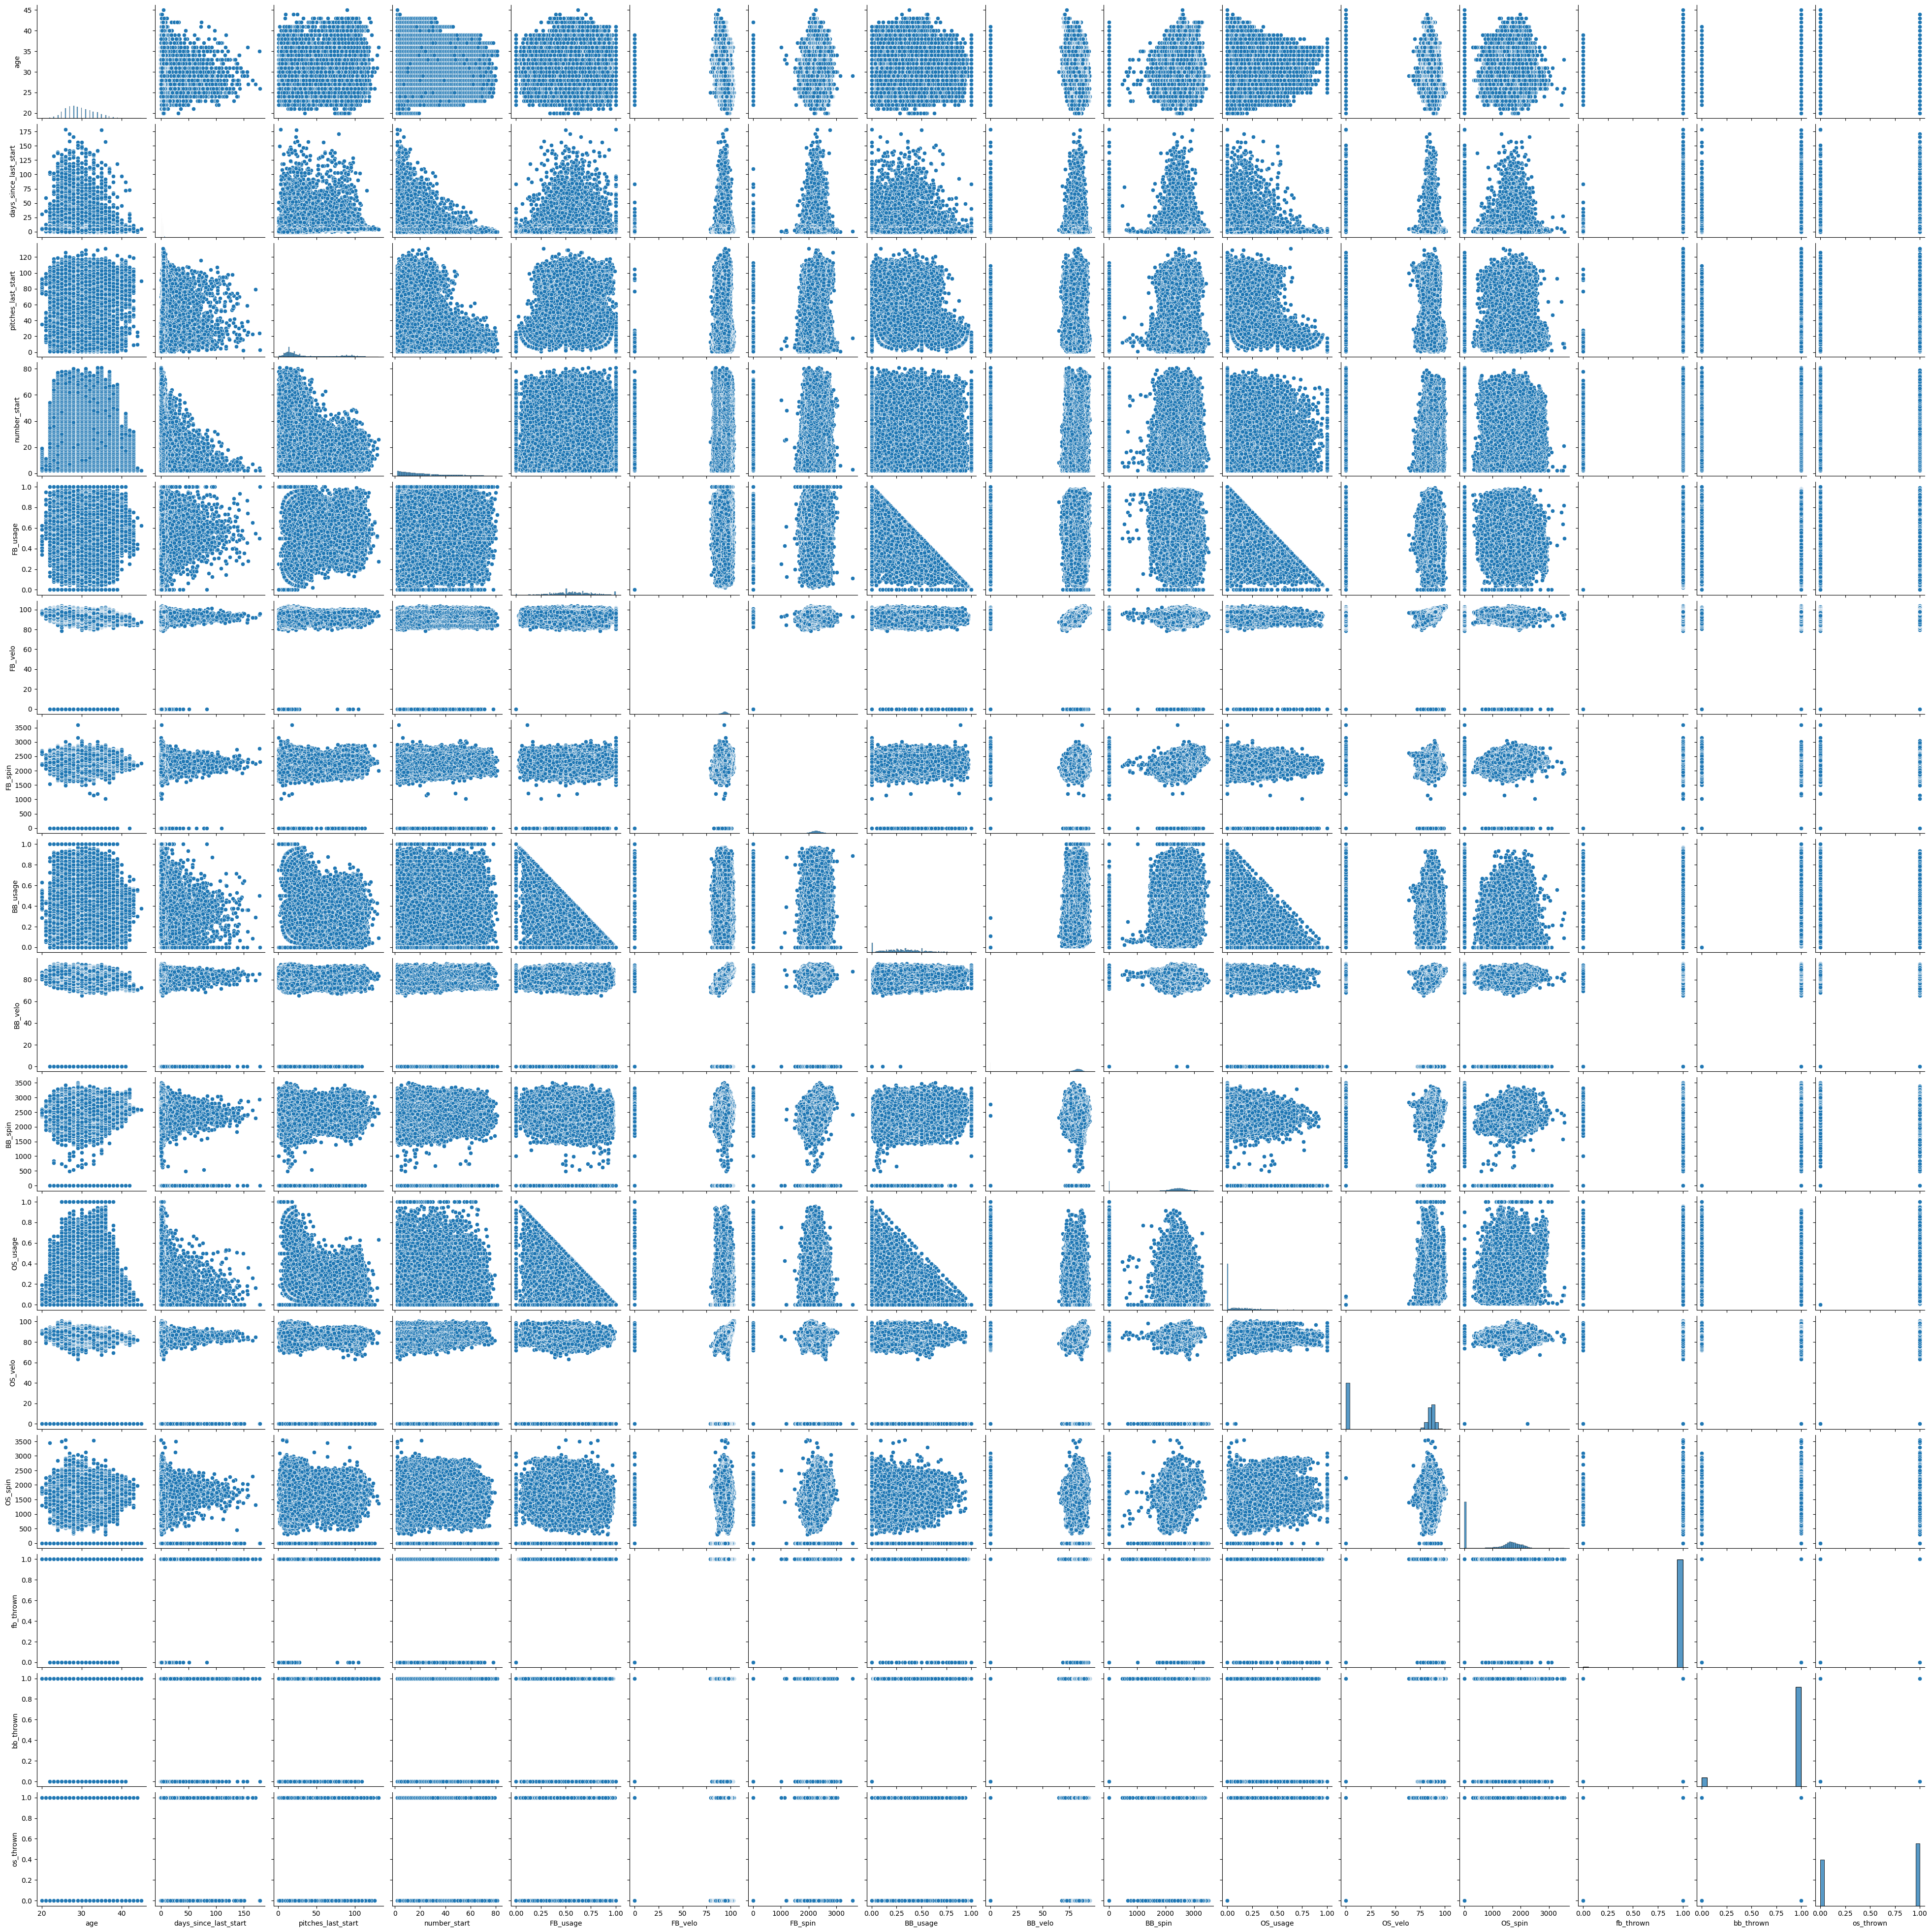

In [125]:
numeric_features = ['age', 'days_since_last_start', 'pitches_last_start', 'number_start', 
                    'FB_usage', 'FB_velo', 'FB_spin', 'BB_usage', 'BB_velo', 'BB_spin', 'OS_usage', 'OS_velo', 'OS_spin', 
                    'fb_thrown', 'bb_thrown', 'os_thrown']

plt.figure()
sns.pairplot(data=pitch_injuries[numeric_features])
plt.show()

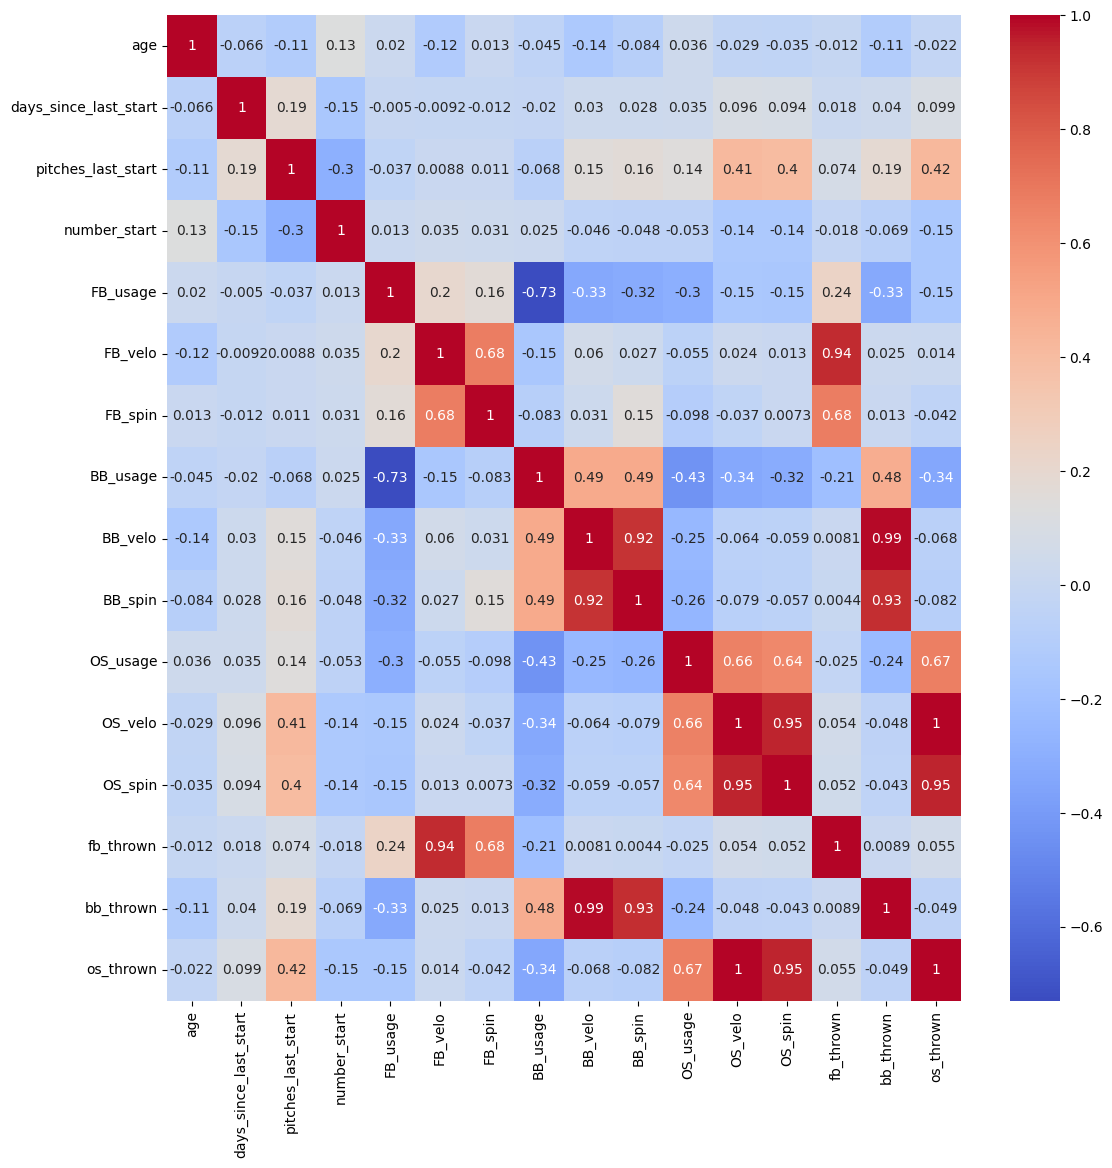

In [128]:
plt.figure(figsize=(pitch_injuries[numeric_features].shape[1]*0.8, pitch_injuries[numeric_features].shape[1]*0.8))
sns.heatmap(data=pitch_injuries[numeric_features].corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [124]:
pitch_injuries['is_workload_inj'].sum()

951